In [1]:
# imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib as plt

[ConfusionMatrixDisplay](https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)
[confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
[balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)
[make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)
[roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

In [2]:
%conda list graphviz

# packages in environment at C:\PyFold\Anaconda\envs\ml_xgboost:
#
# Name                    Version                   Build  Channel
graphviz                  2.50.0               h7eca76f_1  
python-graphviz           0.20.1          py311haa95532_0  

Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_excel('data/Telco_customer_churn.xlsx')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


We will not use last 4 columns, because we don't have this data for prediction for people that didn't churn yet, so it will cause to much weight on prediction and unobtainable at the right moment.
I will leave lables only

In [4]:
df.drop(['Churn Label','Churn Reason','CLTV','Churn Score'], axis=1, inplace=True)

In [5]:
# check useful info and useless wil be dropped
# 1-value :iloc 1 2 3
# duplicate data: 'Lat Long': 6
df.iloc[:,28].unique()

array([1, 0], dtype=int64)

In [6]:
df.drop(df.columns[[1,2,3,6]], axis=1, inplace=True)

In [7]:
df['City'].replace(' ', '_', regex=True, inplace=True)

In [8]:
# im little bit scared of spaces
df.City.unique()

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', ..., 'Standish',
       'Tulelake', 'Olympic_Valley'], dtype=object)

In [9]:
df.columns = df.columns.str.replace(' ','_')

# fixing data
XGBoost can handle missing data so we will replace all misses to zeros

In [10]:
df.dtypes

CustomerID            object
City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [11]:
df.head()
# total charges seems numerical but it is object

,CustomerID,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,3668-QPYBK,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [12]:
df[df.columns[24]].unique()

array([1, 0], dtype=int64)

In [13]:
# didnt get result as i expected, opss
df['Total_Charges'].value_counts()

20.2      11
          11
19.75      9
19.65      8
20.05      8
          ..
444.75     1
5459.2     1
295.95     1
394.1      1
6844.5     1
Name: Total_Charges, Length: 6531, dtype: int64

In [14]:
# pd.to_numeric(df.Total_Charges)
# ValueError: Unable to parse string " " at position 2234

So we find out missing values, and I will deal with it in XGBoost way😎, set them to zeros

In [15]:
len(df.loc[df['Total_Charges']==' '])

11

In [16]:
df.loc[df['Total_Charges']==' ']
#Tenure_Months == 0 thats wy no data

,CustomerID,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,4472-LVYGI,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,3115-CZMZD,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,5709-LVOEQ,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,4367-NUYAO,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,1371-DWPAZ,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,7644-OMVMY,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,3213-VVOLG,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,2520-SGTTA,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,2923-ARZLG,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,4075-WKNIU,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [17]:
df.loc[(df['Total_Charges']==' '), 'Total_Charges'] = 0

In [18]:
df.loc[df['Tenure_Months']==0]
# verified

,CustomerID,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,4472-LVYGI,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,3115-CZMZD,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,5709-LVOEQ,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,4367-NUYAO,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,1371-DWPAZ,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,7644-OMVMY,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,3213-VVOLG,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,2520-SGTTA,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,2923-ARZLG,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,4075-WKNIU,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


In [19]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

CustomerID            object
City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

In [20]:
df.replace(' ', '_', regex=True, inplace=True)

# Formating data to XGBoost model

In [21]:
X = df.drop(['Churn_Value','CustomerID'], axis=1).copy()
y = df['Churn_Value'].copy()

In [22]:
# one hot encoding
X_encoded = pd.get_dummies(X, columns=['City',
                                       'Gender',
                                       'Senior_Citizen',
                                       'Partner',
                                       'Dependents',
                                       'Phone_Service',
                                       'Multiple_Lines',
                                       'Internet_Service',
                                       'Online_Security',
                                       'Online_Backup',
                                       'Device_Protection',
                                       'Tech_Support',
                                       'Streaming_TV',
                                       'Streaming_Movies',
                                       'Contract',
                                       'Paperless_Billing',
                                       'Payment_Method'])

In [23]:
X_encoded.head()
# 1179 col, is what we deserve

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


In [24]:
y.unique()

array([1, 0], dtype=int64)

# Bulding model

In [25]:
sum(y)/len(y)

0.2653698707936959

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=6, stratify=y)

In [27]:
(sum(y_train)/len(y_train), sum(y_test)/len(y_test))

(0.2654297614539947, 0.26519023282226006)

In [28]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=6)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)]
            )

C:\PyFold\Anaconda\envs\ml_xgboost\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\PyFold\Anaconda\envs\ml_xgboost\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.61605
[1]	validation_0-aucpr:0.62668
[2]	validation_0-aucpr:0.64469
[3]	validation_0-aucpr:0.65052
[4]	validation_0-aucpr:0.65180
[5]	validation_0-aucpr:0.65337
[6]	validation_0-aucpr:0.65493
[7]	validation_0-aucpr:0.66096
[8]	validation_0-aucpr:0.65665
[9]	validation_0-aucpr:0.65836
[10]	validation_0-aucpr:0.65792
[11]	validation_0-aucpr:0.65805
[12]	validation_0-aucpr:0.65913
[13]	validation_0-aucpr:0.65842
[14]	validation_0-aucpr:0.65780
[15]	validation_0-aucpr:0.65530
[16]	validation_0-aucpr:0.65179
[17]	validation_0-aucpr:0.65329


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
# i should test a lot of things, seems like i didnt get clf as i expected
print(clf_xgb.max_depth)

None


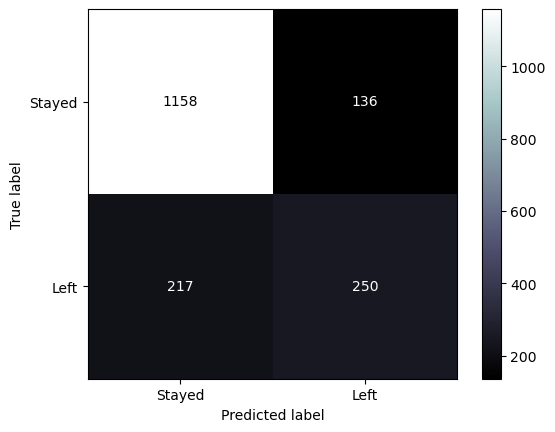

In [30]:
ConfusionMatrixDisplay.from_estimator(clf_xgb,X_test,y_test, display_labels=['Stayed','Left'],cmap=plt.cm.bone)

In [39]:
# optimizing params
# first try
# param_grid = {
#     'max_depth':[3,4,5],
#     'learning_rate':[0.1, 0.05, 0.01],
#     'gamma': [0, 0.25, 1.0],
#     'reg_lambda': [0, 1, 10],
#     'scale_pos_weight':[1, 3, 5]
# }
#  ans = {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'scale_pos_weight': 1}
#
#second try
# param_grid = {
#     'max_depth':[4],
#     'learning_rate':[0.1, 0.2, 0.3],
#     'gamma': [0, 0.1, 0.05],
#     'reg_lambda': [10, 25, 50],
#     'scale_pos_weight':[0.5, 1, 1.5]}
#
# {'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'scale_pos_weight': 1}
# therd try
param_grid = {
    'max_depth':[4],
    'learning_rate':[0.1, 0.12, 0.15],
    'gamma': [0.07, 0.03, 0.05],
    'reg_lambda': [10, 15, 20],
    'scale_pos_weight':[1]}

In [40]:
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=6,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs=10,
    cv=3
)

In [41]:
optimal_params.fit(X_train,
                    y_train,
                    verbose=False,
                    early_stopping_rounds=10,
                    eval_metric='auc',
                    eval_set=[(X_test,y_test)])
print(optimal_params.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\PyFold\Anaconda\envs\ml_xgboost\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\PyFold\Anaconda\envs\ml_xgboost\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'gamma': 0.05, 'learning_rate': 0.12, 'max_depth': 4, 'reg_lambda': 15, 'scale_pos_weight': 1}


In [42]:
# im ok with that
# {'gamma': 0.05, 'learning_rate': 0.12, 'max_depth': 4, 'reg_lambda': 15, 'scale_pos_weight': 1}
# so now clf will be rebuild

In [84]:
clf_xgb=xgb.XGBClassifier(seed=6,
                          objective='binary:logistic',
                          gamma=0.05, learning_rate=0.12, max_depth=4, reg_lambda=15, scale_pos_weight=2.5,
                          subsample=0.9,
                          colsample_bytree=0.5,
                          early_stopping_rounds=10,
                          eval_metric='aucpr',
                          base_score=0.5,
                          booster='gbtree',
                          colsample_bylevel=1,
                          colsample_bynode=1,
                          )

In [86]:
# i decide to put more parametres, i suppose that has been default long ago
clf_xgb.fit(X_train, y_train, verbose=True, eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.56689
[1]	validation_0-aucpr:0.59477
[2]	validation_0-aucpr:0.60727
[3]	validation_0-aucpr:0.61487
[4]	validation_0-aucpr:0.62360
[5]	validation_0-aucpr:0.62484
[6]	validation_0-aucpr:0.62409
[7]	validation_0-aucpr:0.62722
[8]	validation_0-aucpr:0.63156
[9]	validation_0-aucpr:0.63234
[10]	validation_0-aucpr:0.63200
[11]	validation_0-aucpr:0.63292
[12]	validation_0-aucpr:0.64244
[13]	validation_0-aucpr:0.64270
[14]	validation_0-aucpr:0.64348
[15]	validation_0-aucpr:0.64880
[16]	validation_0-aucpr:0.64818
[17]	validation_0-aucpr:0.64920
[18]	validation_0-aucpr:0.64915
[19]	validation_0-aucpr:0.64907
[20]	validation_0-aucpr:0.64944
[21]	validation_0-aucpr:0.64971
[22]	validation_0-aucpr:0.65045
[23]	validation_0-aucpr:0.65089
[24]	validation_0-aucpr:0.65121
[25]	validation_0-aucpr:0.65196
[26]	validation_0-aucpr:0.65401
[27]	validation_0-aucpr:0.65400
[28]	validation_0-aucpr:0.65390
[29]	validation_0-aucpr:0.65317
[30]	validation_0-aucpr:0.65373
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=0.05, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

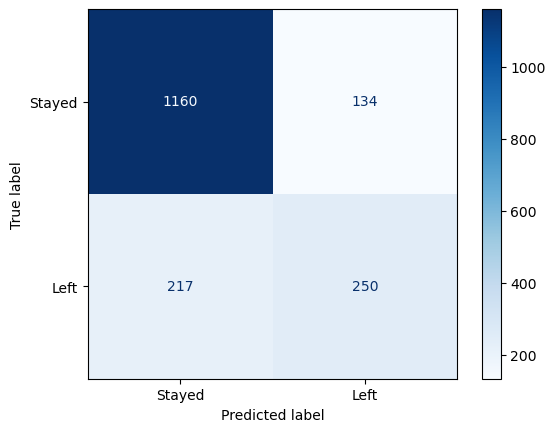

In [83]:
# seems like it little bit better, but it seems like the meain goal is to reduce false positives, thats why i will scale
ConfusionMatrixDisplay.from_estimator(clf_xgb,X_test,y_test, display_labels=['Stayed','Left'],cmap=plt.cm.Blues)

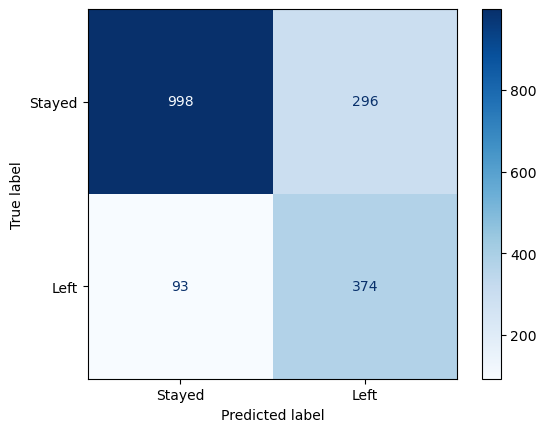

In [87]:
ConfusionMatrixDisplay.from_estimator(clf_xgb,X_test,y_test, display_labels=['Stayed','Left'],cmap=plt.cm.Blues)

374+93 = 467 people leave, 80% of them was correctly clf(was 53% before optimization)


In [90]:
250/467

0.5353319057815846